In [277]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import xgboost as xgb
import math
import csv
import seaborn as sns
plt.style.use('fivethirtyeight')
import plotly.graph_objects as go
#import pycaret.regression as pyr
%matplotlib inline

In [278]:
train_a = pd.read_parquet('../A/train_targets.parquet')
train_b = pd.read_parquet('../B/train_targets.parquet')
train_c = pd.read_parquet('../C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('../A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('../A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('../A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../C/X_test_estimated.parquet')

## Y SET

In [279]:
def find_repeated_rows(df):
    '''
    Returns all indicies (from, to) which have the largest intervals of being constant. The output is sorted from 
    largest to smallest.
    '''
    df = df.reset_index()
    repeated_temp = []
    intervals = []

    first = True

    for index, row in df.iterrows():
        if index == 0:
            continue
        if row['pv_measurement'] == df.iloc[index - 1]['pv_measurement']:
            repeated_temp.append(index)
            if first: 
                repeated_temp.insert(0, index - 1)
                first = False
        else:
            if len(repeated_temp) > 1:
                intervals.append((repeated_temp[0], repeated_temp[-1]))
            repeated_temp = []
            first = True

    return sorted(intervals, key=lambda t: t[1] - t[0], reverse=True)

intervals = find_repeated_rows(train_b)
print("The largest interval is", intervals[0])

The largest interval is (13409, 14466)


In [280]:
all_y = [train_a, train_b, train_c]
labels = ['A', 'B', 'C']

table = {}

i = 0
for y in all_y:
    loc, intervals = labels[i], find_repeated_rows(y)
    if isinstance(intervals[0], (int, float)):
        intervals = np.asarray(intervals, dtype=float)
    intervals = list(intervals) + [np.nan] * (1421 - len(intervals))
    table[loc] = intervals
    print("The largest interval for", loc, intervals[0])
    i += 1

table = pd.DataFrame(table)
table.head()

The largest interval for A (5176, 5218)
The largest interval for B (13409, 14466)
The largest interval for C (18105, 18727)


A               B               C
0    (5176, 5218)  (13409, 14466)  (18105, 18727)
1    (4526, 4547)  (19138, 20141)  (26048, 26669)
2  (22429, 22450)  (18690, 19137)  (27224, 27748)
3  (22933, 22954)  (10966, 11307)  (25400, 25876)
4        (67, 87)  (26115, 26353)  (10047, 10375)

In [281]:
i = 1
for y in all_y[1:]:
    loc, intervals = labels[i], find_repeated_rows(y)
    for start, end in intervals:
        for row_index in range(start, end + 1):
            y.at[row_index, 'pv_measurement'] = np.nan

    test = y.set_index('time')
    #test['pv_measurement'].plot(title="PV measurments when removing all constant intervals in " + loc)
    #plt.show()
    i += 1

In [282]:
train_a.set_index('time', inplace=True)
train_b.set_index('time', inplace=True)
train_c.set_index('time', inplace=True)

In [283]:
full_date_range = pd.date_range(start=train_b.index.min(), end=train_b.index.max(), freq='H')
missing_dates = full_date_range.difference(train_b.index)
missing_df = pd.DataFrame(index=missing_dates)
train_b = pd.concat([train_b, missing_df]).sort_index()

full_date_range = pd.date_range(start=train_c.index.min(), end=train_c.index.max(), freq='H')
missing_dates = full_date_range.difference(train_c.index)
missing_df = pd.DataFrame(index=missing_dates)
train_c = pd.concat([train_c, missing_df]).sort_index()

In [284]:
from sklearn.preprocessing import MinMaxScaler

scaler_a = MinMaxScaler()
scaler_b = MinMaxScaler()
scaler_c = MinMaxScaler()

In [285]:
train_a['pv_measurement'] = scaler_a.fit_transform(train_a[['pv_measurement']])
train_b['pv_measurement'] = scaler_b.fit_transform(train_b[['pv_measurement']])
train_c['pv_measurement'] = scaler_c.fit_transform(train_c[['pv_measurement']])

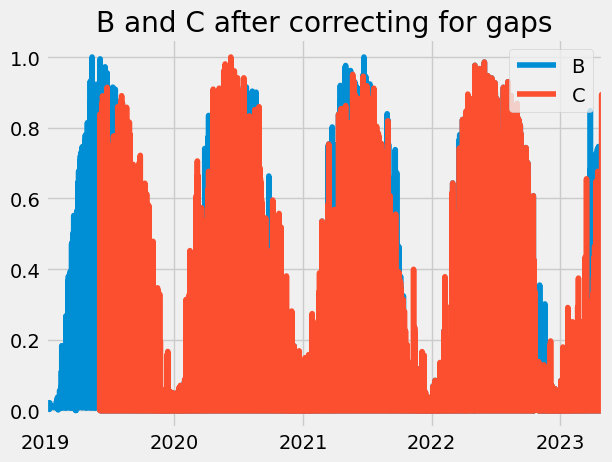

In [286]:
train_b['pv_measurement'] = train_b['pv_measurement'].combine_first(train_a['pv_measurement'])
train_c['pv_measurement'] = train_c['pv_measurement'].combine_first(train_a['pv_measurement'])

train_b['pv_measurement'].plot(title="B and C after correcting for gaps", label = 'B')
train_c['pv_measurement'].plot(label = 'C')
plt.legend()
plt.show()

In [287]:
train_a['location'] = 'A'
train_b['location'] = 'B'
train_c['location'] = 'C'

In [288]:
y = pd.concat([train_a, train_b, train_c])
y.index.name = 'time'
y = pd.get_dummies(y, prefix='location', columns=['location'])
encoded_columns = [col for col in y.columns if 'location_' in col]
y[encoded_columns] = y[encoded_columns].astype(int)

y.shape
y.head()

pv_measurement  location_A  location_B  location_C
time                                                                   
2019-06-02 22:00:00        0.000000           1           0           0
2019-06-02 23:00:00        0.000000           1           0           0
2019-06-03 00:00:00        0.000000           1           0           0
2019-06-03 01:00:00        0.000000           1           0           0
2019-06-03 02:00:00        0.003377           1           0           0

## X SET

In [289]:
all_x_train = [X_train_observed_a, X_train_estimated_a, 
               X_train_observed_b, X_train_estimated_b, 
               X_train_observed_c, X_train_estimated_c]

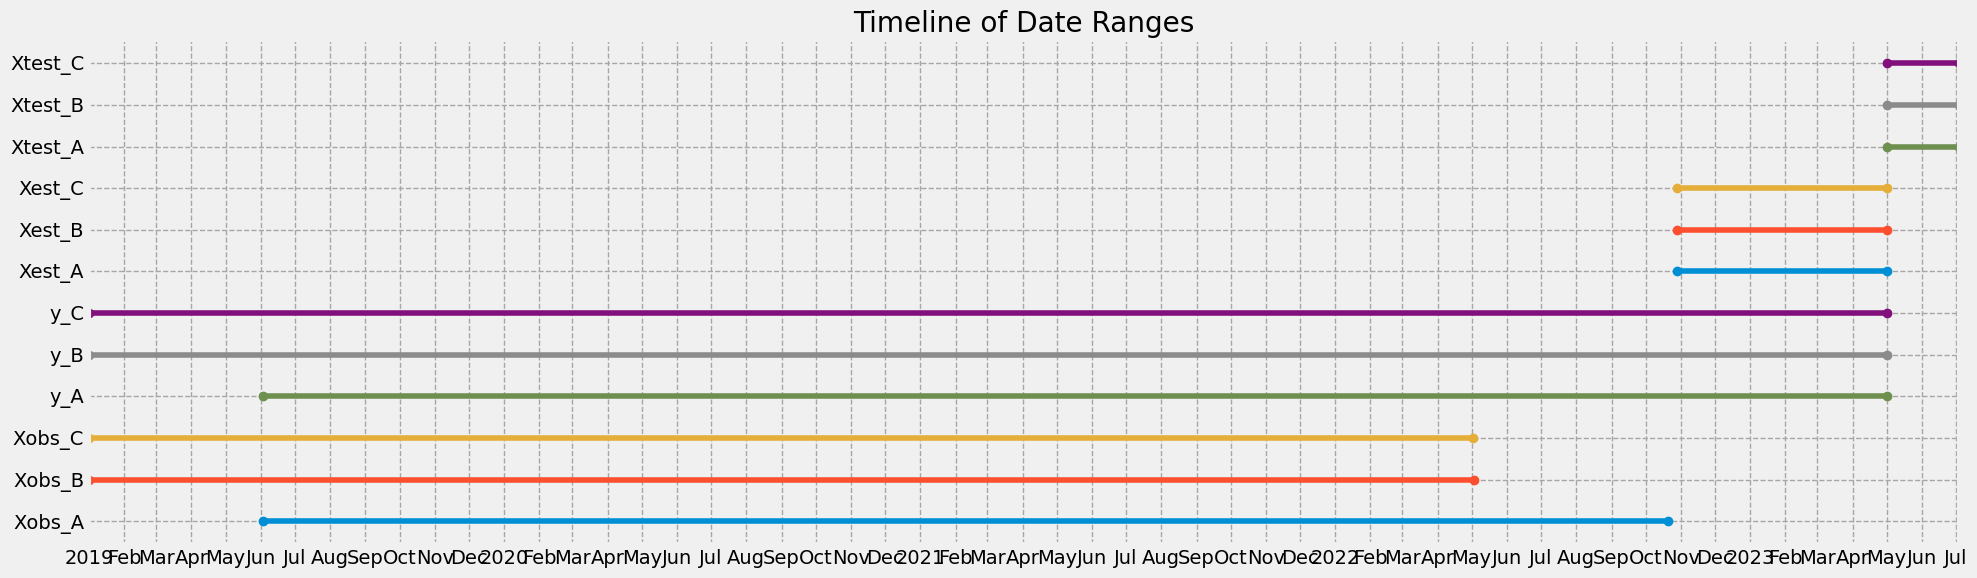

In [290]:
for i in range(len(all_x_train)):
    all_x_train[i]['date_forecast'] = pd.to_datetime(all_x_train[i]['date_forecast'])
    all_x_train[i].set_index('date_forecast', inplace=True)
    if "date_calc" in all_x_train[i]:
        all_x_train[i].drop("date_calc", axis=1, inplace=True)


In [291]:
#appends the rows of df2 below df1. 
def concat_datasets(df1, df2):
    x = pd.concat([df1, df2], ignore_index=False)
    return x

#adds missing dates to the dataset.
def add_missing_dates(df):
    full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
    missing_dates = full_date_range.difference(df.index)
    missing_df = pd.DataFrame(index=missing_dates)
    df = pd.concat([df, missing_df]).sort_index()
    return df

#combines the dataset with the observed data from the training set.
def combine_with_a(df):
    return df.combine_first(X_train_observed_a)

def fix_dataset(obs, est):
    x = concat_datasets(obs, est)
    x = add_missing_dates(x)
    x = x.combine_first(X_train_observed_a)
    return x

In [292]:
x_b = fix_dataset(X_train_observed_b, X_train_estimated_b)
x_c = fix_dataset(X_train_observed_c, X_train_estimated_c)

all_x_train = [X_train_observed_a, X_train_estimated_a, x_b, x_c]

In [293]:
# Sums up the value of every feature for every hour.
for i in range(len(all_x_train)):
    all_x_train[i] = all_x_train[i].resample('60min').sum()

X_train_observed_a, X_train_estimated_a, x_b, x_c = all_x_train

In [294]:
X_train_observed_a['location'], X_train_estimated_a['location'] = 'A', 'A'
x_b['location'] = 'B'
x_c['location'] = 'C'

X_train_observed_a['estimated'], X_train_estimated_a['estimated'] = 0, 1
x_b['estimated'], x_b.loc[x_b.index > X_train_estimated_b.index.min(), 'estimated'] = 0, 1
x_c['estimated'], x_c.loc[x_c.index > X_train_estimated_c.index.min(), 'estimated'] = 0, 1

In [295]:
X = pd.concat(all_x_train, ignore_index=False)
X = X.sort_index()

# One hot encoding
X = pd.get_dummies(X, prefix='location', columns=['location'])
encoded_columns = [col for col in X.columns if 'location_' in col]
X[encoded_columns] = X[encoded_columns].astype(int)

print('Shape of X:', X.shape)
pd.set_option('display.max_columns', None)
X.tail(10)

Shape of X: (109974, 49)


absolute_humidity_2m:gm3  air_density_2m:kgm3  \
2023-04-30 20:00:00                      18.0                5.115   
2023-04-30 21:00:00                      18.0                5.116   
2023-04-30 21:00:00                      18.0                5.124   
2023-04-30 21:00:00                      17.6                5.116   
2023-04-30 22:00:00                      18.0                5.119   
2023-04-30 22:00:00                      17.6                5.119   
2023-04-30 22:00:00                      18.0                5.124   
2023-04-30 23:00:00                      18.0                5.121   
2023-04-30 23:00:00                      18.0                5.124   
2023-04-30 23:00:00                      17.6                5.119   

                     ceiling_height_agl:m  clear_sky_energy_1h:J  \
2023-04-30 20:00:00           7066.000000            9083.099609   
2023-04-30 21:00:00           6795.700195               0.000000   
2023-04-30 21:00:00           6786.600098               0.000000   
2023-04-30 21:00:00           6065.200195               0.000000   
2023-04-30 22:00:00           5419.299805               0.000000   
2023-04-30 22:00:00           4962.399902               0.000000   
2023-04-30 22:00:00           5413.600098               0.000000   
2023-04-30 23:00:00           6511.900391               0.000000   
2023-04-30 23:00:00           6506.299805               0.000000   
2023-04-30 23:00:00           5938.000000               0.000000   

                     clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  \
2023-04-30 20:00:00              0.0       2185.399902              0.0   
2023-04-30 21:00:00              0.0       2192.199951              0.0   
2023-04-30 21:00:00              0.0       2193.399902              0.0   
2023-04-30 21:00:00              0.0       2314.800049              0.0   
2023-04-30 22:00:00              0.0       2110.399902              0.0   
2023-04-30 22:00:00              0.0       2206.000000              0.0   
2023-04-30 22:00:00              0.0       2111.100098              0.0   
2023-04-30 23:00:00              0.0       2104.800049              0.0   
2023-04-30 23:00:00              0.0       2106.100098              0.0   
2023-04-30 23:00:00              0.0       2234.699951              0.0   

                     dew_point_2m:K  diffuse_rad:W  diffuse_rad_1h:J  \
2023-04-30 20:00:00     1089.199951            0.0      20268.099609   
2023-04-30 21:00:00     1089.199951            0.0          0.000000   
2023-04-30 21:00:00     1089.199951            0.0          0.000000   
2023-04-30 21:00:00     1087.599976            0.0          0.000000   
2023-04-30 22:00:00     1089.099976            0.0          0.000000   
2023-04-30 22:00:00     1087.800049            0.0          0.000000   
2023-04-30 22:00:00     1089.199951            0.0          0.000000   
2023-04-30 23:00:00     1089.000000            0.0          0.000000   
2023-04-30 23:00:00     1089.099976            0.0          0.000000   
2023-04-30 23:00:00     1087.800049            0.0          0.000000   

                     direct_rad:W  direct_rad_1h:J  effective_cloud_cover:p  \
2023-04-30 20:00:00           0.0       706.599976               376.899994   
2023-04-30 21:00:00           0.0         0.000000               377.299988   
2023-04-30 21:00:00           0.0         0.000000               377.299988   
2023-04-30 21:00:00           0.0         0.000000               375.700012   
2023-04-30 22:00:00           0.0         0.000000               391.000000   
2023-04-30 22:00:00           0.0         0.000000               393.500000   
2023-04-30 22:00:00           0.0         0.000000               391.100006   
2023-04-30 23:00:00           0.0         0.000000               393.700012   
2023-04-30 23:00:00           0.0         0.000000               393.700012   
2023-04-30 23:00:00           0.0         0.000000               396.399994   

            

In [296]:
df = pd.merge(y, X, left_on=[y.index, 'location_A', 'location_B', 'location_C'],
              right_on=[X.index, 'location_A', 'location_B', 'location_C'])

df.set_index('key_0', inplace=True)
df.index.name = "time"
df = df.sort_index()

df.tail()

pv_measurement  location_A  location_B  location_C  \
time                                                                      
2023-04-30 22:00:00             0.0           0           0           1   
2023-04-30 22:00:00             0.0           1           0           0   
2023-04-30 23:00:00             0.0           0           1           0   
2023-04-30 23:00:00             0.0           1           0           0   
2023-04-30 23:00:00             0.0           0           0           1   

                     absolute_humidity_2m:gm3  air_density_2m:kgm3  \
time                                                                 
2023-04-30 22:00:00                      17.6                5.119   
2023-04-30 22:00:00                      18.0                5.124   
2023-04-30 23:00:00                      18.0                5.121   
2023-04-30 23:00:00                      18.0                5.124   
2023-04-30 23:00:00                      17.6                5.119   

                     ceiling_height_agl:m  clear_sky_energy_1h:J  \
time                                                               
2023-04-30 22:00:00           4962.399902                    0.0   
2023-04-30 22:00:00           5413.600098                    0.0   
2023-04-30 23:00:00           6511.900391                    0.0   
2023-04-30 23:00:00           6506.299805                    0.0   
2023-04-30 23:00:00           5938.000000                    0.0   

                     clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  \
time                                                                      
2023-04-30 22:00:00              0.0       2206.000000              0.0   
2023-04-30 22:00:00              0.0       2111.100098              0.0   
2023-04-30 23:00:00              0.0       2104.800049              0.0   
2023-04-30 23:00:00              0.0       2106.100098              0.0   
2023-04-30 23:00:00              0.0       2234.699951              0.0   

                     dew_point_2m:K  diffuse_rad:W  diffuse_rad_1h:J  \
time                                                                   
2023-04-30 22:00:00     1087.800049            0.0               0.0   
2023-04-30 22:00:00     1089.199951            0.0               0.0   
2023-04-30 23:00:00     1089.000000            0.0               0.0   
2023-04-30 23:00:00     1089.099976            0.0               0.0   
2023-04-30 23:00:00     1087.800049            0.0               0.0   

                     direct_rad:W  direct_rad_1h:J  effective_cloud_cover:p  \
time                                                                          
2023-04-30 22:00:00           0.0              0.0               393.500000   
2023-04-30 22:00:00           0.0              0.0               391.100006   
2023-04-30 23:00:00           0.0              0.0               393.700012   
2023-04-30 23:00:00           0.0              0.0               393.700012   
2023-04-30 23:00:00           0.0              0.0               396.399994   

                     elevation:m  fresh_snow_12h:cm  fresh_snow_1h:cm  \
time                                                                    
2023-04-30 22:00:00         96.0                0.0               0.0   
2023-04-30 22:00:00         24.0                0.0               0.0   
2023-04-30 23:00:00         28.0                0.0               0.0   
2023-04-30 23:00:00         24.0                0.0               0.0   
2023-04-30 23:00:00         96.0                0.0               0.0   

                     fresh_snow_24h:cm  fresh_snow_3h:cm  fresh_snow_6h:cm  \
time                                                                         
2023-04-30 22:00:00                1.2               0.0               0.0   
2023-04-30 22:00:00                0.0               0.0               0.0   
2023-04-30 23:00:00                0.0               0.0               0.0   
2023-04-30 23:00:00                0.0  

### Features from the categorical datetime64[US]

Comment: It looks like day of week is fucked?

In [297]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)
df.head()

pv_measurement  location_A  location_B  location_C  \
time                                                                      
2019-01-01 00:00:00             NaN           0           0           1   
2019-01-01 00:00:00             NaN           0           1           0   
2019-01-01 01:00:00             NaN           0           1           0   
2019-01-01 01:00:00             NaN           0           0           1   
2019-01-01 02:00:00             NaN           0           1           0   

                     absolute_humidity_2m:gm3  air_density_2m:kgm3  \
time                                                                 
2019-01-01 00:00:00                 21.900000                4.963   
2019-01-01 00:00:00                 22.100000                4.959   
2019-01-01 01:00:00                 21.700001                4.959   
2019-01-01 01:00:00                 21.400002                4.960   
2019-01-01 02:00:00                 21.600000                4.954   

                     ceiling_height_agl:m  clear_sky_energy_1h:J  \
time                                                               
2019-01-01 00:00:00           4520.100098                    0.0   
2019-01-01 00:00:00           4802.700195                    0.0   
2019-01-01 01:00:00           4525.699707                    0.0   
2019-01-01 01:00:00           4266.699707                    0.0   
2019-01-01 02:00:00           4244.000000                    0.0   

                     clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  \
time                                                                      
2019-01-01 00:00:00              0.0       4520.100098              4.0   
2019-01-01 00:00:00              0.0       4802.700195              0.0   
2019-01-01 01:00:00              0.0       4525.699707              0.0   
2019-01-01 01:00:00              0.0       4266.699707              3.0   
2019-01-01 02:00:00              0.0       4244.000000              0.0   

                     dew_point_2m:K  diffuse_rad:W  diffuse_rad_1h:J  \
time                                                                   
2019-01-01 00:00:00     1099.900024            0.0               0.0   
2019-01-01 00:00:00     1100.599976            0.0               0.0   
2019-01-01 01:00:00     1099.300049            0.0               0.0   
2019-01-01 01:00:00     1098.599976            0.0               0.0   
2019-01-01 02:00:00     1099.199951            0.0               0.0   

                     direct_rad:W  direct_rad_1h:J  effective_cloud_cover:p  \
time                                                                          
2019-01-01 00:00:00           0.0              0.0               314.799988   
2019-01-01 00:00:00           0.0              0.0               327.299988   
2019-01-01 01:00:00           0.0              0.0               389.899994   
2019-01-01 01:00:00           0.0              0.0               389.500000   
2019-01-01 02:00:00           0.0              0.0               385.700012   

                     elevation:m  fresh_snow_12h:cm  fresh_snow_1h:cm  \
time                                                                    
2019-01-01 00:00:00         96.0                0.0               0.0   
2019-01-01 00:00:00         28.0                0.0               0.0   
2019-01-01 01:00:00         28.0                0.0               0.0   
2019-01-01 01:00:00         96.0                0.0               0.0   
2019-01-01 02:00:00         28.0                0.0               0.0   

                     fresh_snow_24h:cm  fresh_snow_3h:cm  fresh_snow_6h:cm  \
time                                                                         
2019-01-01 00:00:00                0.0               0.0               0.0   
2019-01-01 00:00:00                0.0               0.0               0.0   
2019-01-01 01:00:00                0.0               0.0               0.0   
2019-01-01 01:00:00                0.0  

Choosing features

In [298]:
FEATURES = [
    'direct_rad_1h:J', 'effective_cloud_cover:p', 'clear_sky_energy_1h:J',
    'visibility:m', 'sun_elevation:d', 'is_day:idx', 'clear_sky_rad:W',
    'is_in_shadow:idx', 'sun_azimuth:d',
    'hour', 'dayofweek', 'quarter', 'month', 
    'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'location_A', 'location_B', 'location_C', 
    'estimated'
]

TARGET = 'pv_measurement'

In [299]:
relevant = FEATURES.copy()
relevant.append(TARGET)

df = df[relevant]

In [300]:
print(df.isna().sum())
before = df.shape

train = df.dropna()
print(train.isna().sum())
after = train.shape

dif = before[0] - after[0]
print("DROPNA RESULTED IN", dif, "ROWS BEING DROPPED. THE DATASET HAS", after[0], "ROWS IN TOTAL.")

direct_rad_1h:J               0
effective_cloud_cover:p       0
clear_sky_energy_1h:J         0
visibility:m                  0
sun_elevation:d               0
is_day:idx                    0
clear_sky_rad:W               0
is_in_shadow:idx              0
sun_azimuth:d                 0
hour                          0
dayofweek                     0
quarter                       0
month                         0
year                          0
dayofyear                     0
dayofmonth                    0
weekofyear                    0
location_A                    0
location_B                    0
location_C                    0
estimated                     0
pv_measurement             6171
dtype: int64
direct_rad_1h:J            0
effective_cloud_cover:p    0
clear_sky_energy_1h:J      0
visibility:m               0
sun_elevation:d            0
is_day:idx                 0
clear_sky_rad:W            0
is_in_shadow:idx           0
sun_azimuth:d              0
hour                  

In [301]:
df = df.dropna()

In [302]:
color_pal = sns.color_palette()
fig = go.Figure()

fig.add_trace(go.Scatter(x=df.index,
                         y=df["pv_measurement"],
                         mode='markers',
                         marker=dict(color='orange'),
                         name='PV Measurement'))

# Set the plot title and layout
fig.update_layout(title='PV measurement against time',
                  xaxis_title='Time',
                  yaxis_title='PV Measurement',
                  width=900,
                  height=300)

# Display the plot
fig.show()

### Adding Lag Variables

In [303]:
def create_lags(df, column, lags):
    for lag in lags:
        name = f"{column}_lag_{lag}"
        df[f"{column}_lag_{lag}"] = df[column].shift(lag)
        if name not in FEATURES:
            FEATURES.append(name)
    return df

lag_definitions = {
    "is_day:idx": [1, 24, 48],
    "clear_sky_rad:W": [1, 24],
    "is_in_shadow:idx": [1, 24, 48],
    "sun_azimuth:d": [1, 24],
    #"pv_measurement": [1, 24]
}

for column, lags in lag_definitions.items():
    df = create_lags(df, column, lags)

df.head()

direct_rad_1h:J  effective_cloud_cover:p  \
time                                                            
2019-01-01 10:00:00       140.500000               399.400024   
2019-01-01 11:00:00       313.600006               396.299988   
2019-01-01 12:00:00      1356.000000               385.399994   
2019-01-01 13:00:00      1183.000000               382.200012   
2019-01-02 10:00:00       264.100006               400.000000   

                     clear_sky_energy_1h:J  visibility:m  sun_elevation:d  \
time                                                                        
2019-01-01 10:00:00           178143.09375  15510.099609           10.716   
2019-01-01 11:00:00           357289.31250  52637.398438           13.821   
2019-01-01 12:00:00           353490.90625  83163.398438           10.473   
2019-01-01 13:00:00           170034.50000  47947.199219            0.910   
2019-01-02 10:00:00           185088.09375  63841.699219           10.994   

                     is_day:idx  clear_sky_rad:W  is_in_shadow:idx  \
time                                                                 
2019-01-01 10:00:00         4.0        81.300003               0.0   
2019-01-01 11:00:00         4.0       108.300003               0.0   
2019-01-01 12:00:00         4.0        79.400002               0.0   
2019-01-01 13:00:00         2.0        14.900000               4.0   
2019-01-02 10:00:00         4.0        83.699997               0.0   

                     sun_azimuth:d  hour  dayofweek  quarter  month  year  \
time                                                                        
2019-01-01 10:00:00     665.742981    10          1        1      1  2019   
2019-01-01 11:00:00     721.046021    11          1        1      1  2019   
2019-01-01 12:00:00     776.333984    12          1        1      1  2019   
2019-01-01 13:00:00     830.840027    13          1        1      1  2019   
2019-01-02 10:00:00     665.275024    10          2        1      1  2019   

                     dayofyear  dayofmonth  weekofyear  location_A  \
time                                                                 
2019-01-01 10:00:00          1           1           1           0   
2019-01-01 11:00:00          1           1           1           0   
2019-01-01 12:00:00          1           1           1           0   
2019-01-01 13:00:00          1           1           1           0   
2019-01-02 10:00:00          2           2           1           0   

                     location_B  location_C  estimated  pv_measurement  \
time                                                                     
2019-01-01 10:00:00           1           0          0        0.000749   
2019-01-01 11:00:00           1           0          0        0.008982   
2019-01-01 12:00:00           1           0          0        0.004491   
2019-01-01 13:00:00           1           0          0        0.000749   
2019-01-02 10:00:00           1           0          0        0.002994   

                     is_day:idx_lag_1  is_day:idx_lag_24  is_day:idx_lag_48  \
time                                                                          
2019-01-01 10:00:00               NaN                NaN                NaN   
2019-01-01 11:00:00               4.0                NaN                NaN   
2019-01-01 12:00:00               4.0                NaN                NaN   
2019-01-01 13:00:00               4.0                NaN                NaN   
2019-01-02 10:00:00               2.0                NaN                NaN   

                     clear_sky_rad:W_lag_1  clear_sky_rad:W_lag_24  \
time                                                                 
2019-01-01 10:00:00                    NaN                     NaN   
2019-01-01 11:00:00              81.300003                     NaN   
2019-01-01 12:00:00             108.300003                     NaN   
2019-01-01 13:00:00              79.400002                     NaN   
2019-01-02

In [304]:
print(df.isna().sum())
before = df.shape

train = df.dropna()
print(train.isna().sum())
after = train.shape

dif = before[0] - after[0]
print("DROPNA RESULTED IN", dif, "ROWS BEING DROPPED. THE DATASET HAS", after[0], "ROWS IN TOTAL.")

direct_rad_1h:J             0
effective_cloud_cover:p     0
clear_sky_energy_1h:J       0
visibility:m                0
sun_elevation:d             0
is_day:idx                  0
clear_sky_rad:W             0
is_in_shadow:idx            0
sun_azimuth:d               0
hour                        0
dayofweek                   0
quarter                     0
month                       0
year                        0
dayofyear                   0
dayofmonth                  0
weekofyear                  0
location_A                  0
location_B                  0
location_C                  0
estimated                   0
pv_measurement              0
is_day:idx_lag_1            1
is_day:idx_lag_24          24
is_day:idx_lag_48          48
clear_sky_rad:W_lag_1       1
clear_sky_rad:W_lag_24     24
is_in_shadow:idx_lag_1      1
is_in_shadow:idx_lag_24    24
is_in_shadow:idx_lag_48    48
sun_azimuth:d_lag_1         1
sun_azimuth:d_lag_24       24
dtype: int64
direct_rad_1h:J            

In [305]:
df = df.dropna()

In [306]:
# Fixing for A
X_train_estimated_a.drop('location', axis=1, inplace=True)
X_train_estimated_a = create_features(X_train_estimated_a)
# location A already has an "estimated" column

# Fixing for B
X_train_estimated_b = X_train_estimated_b.resample('60min').sum()
X_train_estimated_b = create_features(X_train_estimated_b)
X_train_estimated_b['estimated'] = 1

# Fixing for C
X_train_estimated_c = X_train_estimated_c.resample('60min').sum()
X_train_estimated_c = create_features(X_train_estimated_c)
X_train_estimated_c['estimated'] = 1

X_train_estimated_b.head()

absolute_humidity_2m:gm3  air_density_2m:kgm3  \
date_forecast                                                        
2022-10-28 22:00:00                 33.599998                4.930   
2022-10-28 23:00:00                 33.400002                4.928   
2022-10-29 00:00:00                 32.400002                4.916   
2022-10-29 01:00:00                 32.799999                4.913   
2022-10-29 02:00:00                 33.500000                4.907   

                     ceiling_height_agl:m  clear_sky_energy_1h:J  \
date_forecast                                                      
2022-10-28 22:00:00           9665.799805                    0.0   
2022-10-28 23:00:00          16141.000000                    0.0   
2022-10-29 00:00:00           7523.500000                    0.0   
2022-10-29 01:00:00           6490.399902                    0.0   
2022-10-29 02:00:00           5288.899902                    0.0   

                     clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  \
date_forecast                                                             
2022-10-28 22:00:00              0.0       6951.200195              4.0   
2022-10-28 23:00:00              0.0       8259.200195              4.0   
2022-10-29 00:00:00              0.0       6694.399902              4.0   
2022-10-29 01:00:00              0.0       6190.299805              4.0   
2022-10-29 02:00:00              0.0       4215.299805              4.0   

                     dew_point_2m:K  diffuse_rad:W  diffuse_rad_1h:J  \
date_forecast                                                          
2022-10-28 22:00:00     1125.800049            0.0               0.0   
2022-10-28 23:00:00     1124.900024            0.0               0.0   
2022-10-29 00:00:00     1123.599976            0.0               0.0   
2022-10-29 01:00:00     1124.199951            0.0               0.0   
2022-10-29 02:00:00     1125.399902            0.0               0.0   

                     direct_rad:W  direct_rad_1h:J  effective_cloud_cover:p  \
date_forecast                                                                 
2022-10-28 22:00:00           0.0              0.0                    400.0   
2022-10-28 23:00:00           0.0              0.0                    400.0   
2022-10-29 00:00:00           0.0              0.0                    400.0   
2022-10-29 01:00:00           0.0              0.0                    400.0   
2022-10-29 02:00:00           0.0              0.0                    400.0   

                     elevation:m  fresh_snow_12h:cm  fresh_snow_1h:cm  \
date_forecast                                                           
2022-10-28 22:00:00         28.0                0.0               0.0   
2022-10-28 23:00:00         28.0                0.0               0.0   
2022-10-29 00:00:00         28.0                0.0               0.0   
2022-10-29 01:00:00         28.0                0.0               0.0   
2022-10-29 02:00:00         28.0                0.0               0.0   

                     fresh_snow_24h:cm  fresh_snow_3h:cm  fresh_snow_6h:cm  \
date_forecast                                                                
2022-10-28 22:00:00                0.0               0.0               0.0   
2022-10-28 23:00:00                0.0               0.0               0.0   
2022-10-29 00:00:00                0.0               0.0               0.0   
2022-10-29 01:00:00                0.0               0.0               0.0   
2022-10-29 02:00:00                0.0               0.0               0.0   

                     is_day:idx  is_in_shadow:idx  msl_pressure:hPa  \
date_forecast                                                         
2022-10-28 22:00:00         0.0               4.0       4002.600098   
2022-10-28 23:00:00         0.0               4.0       3998.399902   
2022-10-29 00:00:00         0.0               4.0       3988.000000   
2022-10-29 01:00:00         0.0               4.0     

In [307]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def prepare_test_data(x, location):
    x_test = x.copy()
    x_test.set_index('date_forecast', inplace = True)

    x_test = drop_data(x_test)
    x_test = add_missing_dates(x_test)
    x_test = impute_missing_data(x_test)

    # Might change order of this
    x_test = x_test.resample('60min').sum()
    
    cap_date = x_test.index.min()

    x_test = create_features(x_test)
    x_test['estimated'] = 1

    if location == 'A':
        x_test['location_A'], X_train_estimated_a['location_A'] = 1, 1
        x_test['location_B'], X_train_estimated_a['location_B'] = 0, 0
        x_test['location_C'], X_train_estimated_a['location_C'] = 0, 0

        x_test = concat_and_lagify(x_test, X_train_estimated_a)
    elif location == 'B':
        x_test['location_A'], X_train_estimated_a['location_A'] = 0, 0
        x_test['location_B'], X_train_estimated_a['location_B'] = 1, 1
        x_test['location_C'], X_train_estimated_a['location_C'] = 0, 0

        x_test = concat_and_lagify(x_test, X_train_estimated_b)
    elif location == 'C':
        x_test['location_A'], X_train_estimated_a['location_A'] = 0, 0
        x_test['location_B'], X_train_estimated_a['location_B'] = 0, 0
        x_test['location_C'], X_train_estimated_a['location_C'] = 1, 1

        x_test = concat_and_lagify(x_test, X_train_estimated_c)

    x_test = x_test.loc[cap_date:]
    return x_test

def create_lag_variables(x):
    lag_definitions = {
        "is_day:idx": [1, 24, 48],
        "clear_sky_rad:W": [1, 24],
        "is_in_shadow:idx": [1, 24, 48],
        "sun_azimuth:d": [1, 24],
    }

    for column, lags in lag_definitions.items():
        x = create_lags(x, column, lags)
    return x

def concat_and_lagify(df1, df2):
    df1 = pd.concat([df1, df2], ignore_index=False)
    df1 = df1.sort_index()
    df1 = create_lag_variables(df1)
    df1 = df1[FEATURES]
    return df1

def add_missing_dates(df):
    full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
    missing_dates = full_date_range.difference(df.index)
    missing_df = pd.DataFrame(index=missing_dates)
    df = pd.concat([df, missing_df]).sort_index()
    return df

def impute_missing_data(df):
    df = df.astype('float64')

    original_index = df.index

    imputer = IterativeImputer(random_state=42)
    imputed = imputer.fit_transform(df)
    df = pd.DataFrame(imputed, columns=df.columns, index=original_index)
    return df

def drop_data(df):
    df.drop(['ceiling_height_agl:m', 'cloud_base_agl:m', 
                             'snow_density:kgm3', 'date_calc'], axis=1, inplace=True)
    return df

In [308]:
x_test_a = prepare_test_data(X_test_estimated_a, 'A')
x_test_b = prepare_test_data(X_test_estimated_b, 'B')
x_test_c = prepare_test_data(X_test_estimated_c, 'C')

<Axes: >

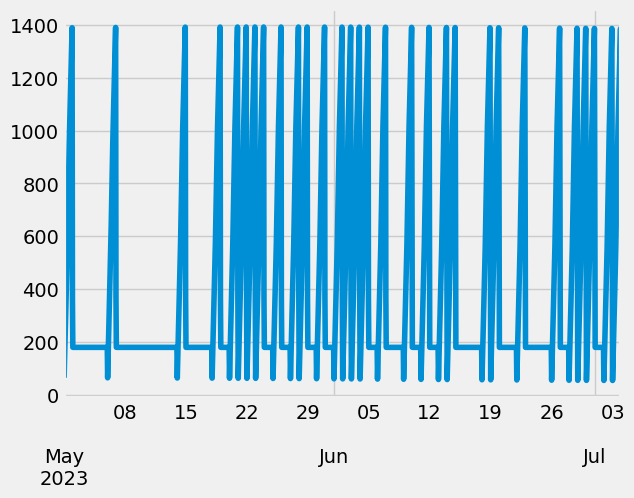

In [310]:
test_sub = pd.read_csv('../test.csv')
valid_dates = pd.to_datetime(test_sub['time'].unique())
x_test_a['sun_azimuth:d'].plot()

In [311]:
x_test_a = x_test_a.loc[valid_dates]
x_test_b = x_test_a.loc[valid_dates]
x_test_c = x_test_a.loc[valid_dates]

In [312]:
print(x_test_a.shape, x_test_b.shape, x_test_c.shape)
print(X_test_estimated_a.shape, X_test_estimated_b.shape, X_test_estimated_c.shape)

(720, 31) (720, 31) (720, 31)
(2880, 47) (2880, 47) (2880, 47)


In [313]:
X_test = pd.concat([x_test_a, x_test_b, x_test_c])

In [314]:
X_test.tail(5)

direct_rad_1h:J  effective_cloud_cover:p  \
2023-07-03 19:00:00    203853.000000               342.300003   
2023-07-03 20:00:00    122263.498047               298.400002   
2023-07-03 21:00:00     25639.599854               304.500000   
2023-07-03 22:00:00         0.000000               392.900002   
2023-07-03 23:00:00         0.000000               400.000000   

                     clear_sky_energy_1h:J   visibility:m  sun_elevation:d  \
2023-07-03 19:00:00           1.908373e+06  176225.503906           32.612   
2023-07-03 20:00:00           7.373427e+05  176068.699219           13.072   
2023-07-03 21:00:00           1.497173e+05  173208.199219           -1.773   
2023-07-03 22:00:00           1.440200e+03  162023.406250          -11.002   
2023-07-03 23:00:00           0.000000e+00  158662.101562          -13.990   

                     is_day:idx  clear_sky_rad:W  is_in_shadow:idx  \
2023-07-03 19:00:00         4.0       340.399998               0.0   
2023-07-03 20:00:00         4.0        99.199999               0.0   
2023-07-03 21:00:00         1.0         5.100000               4.0   
2023-07-03 22:00:00         0.0         0.000000               4.0   
2023-07-03 23:00:00         0.0         0.000000               4.0   

                     sun_azimuth:d  hour  dayofweek  quarter  month  year  \
2023-07-03 19:00:00    1226.747986    19          0        3      7  2023   
2023-07-03 20:00:00    1278.816010    20          0        3      7  2023   
2023-07-03 21:00:00    1332.160004    21          0        3      7  2023   
2023-07-03 22:00:00    1386.744019    22          0        3      7  2023   
2023-07-03 23:00:00     722.073997    23          0        3      7  2023   

                     dayofyear  dayofmonth  weekofyear  location_A  \
2023-07-03 19:00:00        184           3          27           1   
2023-07-03 20:00:00        184           3          27           1   
2023-07-03 21:00:00        184           3          27           1   
2023-07-03 22:00:00        184           3          27           1   
2023-07-03 23:00:00        184           3          27           1   

                     location_B  location_C  estimated  is_day:idx_lag_1  \
2023-07-03 19:00:00           0           0          1               4.0   
2023-07-03 20:00:00           0           0          1               4.0   
2023-07-03 21:00:00           0           0          1               4.0   
2023-07-03 22:00:00           0           0          1               1.0   
2023-07-03 23:00:00           0           0          1               0.0   

                     is_day:idx_lag_24  is_day:idx_lag_48  \
2023-07-03 19:00:00                4.0            0.79375   
2023-07-03 20:00:00                4.0            0.79375   
2023-07-03 21:00:00                1.0            0.79375   
2023-07-03 22:00:00                0.0            0.79375   
2023-07-03 23:00:00                0.0            0.79375   

                     clear_sky_rad:W_lag_1  clear_sky_rad:W_lag_24  \
2023-07-03 19:00:00             741.099991              343.400002   
2023-07-03 20:00:00             340.399998              101.100000   
2023-07-03 21:00:00              99.199999                5.600000   
2023-07-03 22:00:00               5.100000                0.000000   
2023-07-03 23:00:00               0.000000                0.000000   

                     is_in_shadow:idx_lag_1  is_in_shadow:idx_lag_24  \
2023-07-03 19:00:00                     0.0                      0.0   
2023-07-03 20:00:00                     0.0                      0.0   
2023-07-03 21:00:00                     0.0                      4.0   
2023-07-03 22:00:00                     4.0                      4.0   
2023-07-03 23:00:00                     4.0                      4.0   

                     is_in_shadow:idx_lag_48  sun_azimuth:d_lag_1  \
2023-07-03 19:00:00                 0.225347          1175.472992   
2023-07-03 20:00:00                 0.22

In [315]:
differences = X_test.index.to_series().diff().value_counts()
print(differences)

0 days 01:00:00       2106
1 days 01:00:00         30
3 days 01:00:00          9
2 days 01:00:00          6
4 days 01:00:00          3
7 days 01:00:00          3
-64 days +01:00:00       2
Name: count, dtype: int64


In [316]:
q = df.copy()
q = q[FEATURES]
q.columns

Index(['direct_rad_1h:J', 'effective_cloud_cover:p', 'clear_sky_energy_1h:J',
       'visibility:m', 'sun_elevation:d', 'is_day:idx', 'clear_sky_rad:W',
       'is_in_shadow:idx', 'sun_azimuth:d', 'hour', 'dayofweek', 'quarter',
       'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'location_A',
       'location_B', 'location_C', 'estimated', 'is_day:idx_lag_1',
       'is_day:idx_lag_24', 'is_day:idx_lag_48', 'clear_sky_rad:W_lag_1',
       'clear_sky_rad:W_lag_24', 'is_in_shadow:idx_lag_1',
       'is_in_shadow:idx_lag_24', 'is_in_shadow:idx_lag_48',
       'sun_azimuth:d_lag_1', 'sun_azimuth:d_lag_24'],
      dtype='object')

### Imbecile check

In [317]:
check_df = df.copy()
check_train = check_df[FEATURES]
if X_test.columns.equals(check_train.columns):
    print("EQUAL")
else:
    print("NOT EQUAL")

EQUAL


In [318]:
X_test.shape

(2160, 31)

In [319]:
X_train = df[FEATURES]
y_train = df[TARGET]

In [320]:
if X_test.shape[0] != 2160:
    print("X_test has wrong amount of rows!")
    print("Shape =", X_test.shape[0])
else:
    print("GOOD")

GOOD


# LSTM

In [272]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit

In [273]:
cv_split = TimeSeriesSplit(n_splits=5)

In [274]:
TIME_STEPS = 24

def create_sequences(X, y, time_steps=TIME_STEPS):
    X_seq, y_seq = [], []

    for i in range(len(X) - time_steps):
        X_seq.append(X[i:(i + time_steps)])
        y_seq.append(y[i + time_steps])

    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_train, y_train)

# 3. LSTM Model
model = Sequential()

model.add(LSTM(50, activation='relu', input_shape=(X_seq.shape[1], X_seq.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 4. Training
model.fit(X_seq, y_seq, epochs=50, batch_size=32, validation_split=0.2, shuffle=False)

/var/folders/4j/dxkybcjx57g2_q7pvt8nkd040000gn/T/ipykernel_12074/3245196033.py:8: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



KeyboardInterrupt: 

In [ ]:
predictions = model.predict(X_test)

In [ ]:
predictions = pd.DataFrame(predictions, columns=['prediction'])

n = len(predictions)

# De-normalizing
predictions.loc[:n//3, 'prediction'] = scaler_a.inverse_transform(predictions.loc[:n//3, 'prediction'].values.reshape(-1, 1))[:, 0]
predictions.loc[n//3:2*n//3, 'prediction'] = scaler_b.inverse_transform(predictions.loc[n//3:2*n//3, 'prediction'].values.reshape(-1, 1))[:, 0]
predictions.loc[2*n//3:, 'prediction'] = scaler_c.inverse_transform(predictions.loc[2*n//3:, 'prediction'].values.reshape(-1, 1))[:, 0]


predictions.reset_index(inplace=True)
predictions.rename(columns={'index': 'id'}, inplace=True)
predictions.to_csv('predictions.csv', index=False)